# Notebook 2 — User-Level Aggregation from Feeds Logs

**Goal**  
Transform the feeds behavior logs (many rows per user)  
into a *user-level profile table* (one row per user).

**Input**
- `feeds_train_clean.parquet`
- `feeds_test_clean.parquet`

**Output**
- `feeds_user_agg_train.parquet`
- `feeds_user_agg_test.parquet`

In [5]:
# Step 1 — Load cleaned feeds datasets
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

# Load from Notebook 1 saved outputs
feeds_train_clean = pd.read_parquet('feeds_train_clean.parquet')
feeds_test_clean  = pd.read_parquet('feeds_test_clean.parquet')

print("Feeds datasets loaded successfully!")
print("Train feeds shape:", feeds_train_clean.shape)
print("Test feeds shape:", feeds_test_clean.shape)

Feeds datasets loaded successfully!
Train feeds shape: (3227732, 39)
Test feeds shape: (369341, 39)


## Step 2 — Inspect basic structure

We’ll check:
- Column names and dtypes
- Presence of key identifiers (`u_userId`)
- Existence of derived columns from cleaning (`t_hour`, `_len`, `_uniq`)

In [8]:
# Step 2 — Quick inspection
print("\n===== Training Feeds (Preview) =====")
print("Columns:", list(feeds_train_clean.columns)[:30])
print("Sample rows:")
display(feeds_train_clean.head(3))

# Ensure key columns exist
required_cols = ['u_userId', 't_hour', 't_wday', 't_is_weekend']
missing = [c for c in required_cols if c not in feeds_train_clean.columns]
print("\nMissing essential columns:", missing if missing else "None")


===== Training Feeds (Preview) =====
Columns: ['u_userId', 'u_phonePrice', 'u_browserLifeCycle', 'u_browserMode', 'u_feedLifeCycle', 'u_refreshTimes', 'u_newsCatInterests', 'u_newsCatDislike', 'u_newsCatInterestsST', 'u_click_ca2_news', 'i_docId', 'i_s_sourceId', 'i_regionEntity', 'i_cat', 'i_entities', 'i_dislikeTimes', 'i_upTimes', 'i_dtype', 'e_ch', 'e_m', 'e_po', 'e_pl', 'e_rn', 'e_section', 'e_et', 'label', 'cillabel', 'pro', 't_hour', 't_wday']
Sample rows:


,u_userId,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,i_docId,i_s_sourceId,i_regionEntity,i_cat,i_entities,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro,t_hour,t_wday,t_is_weekend,u_newsCatInterests_len,u_newsCatInterests_uniq,u_newsCatInterestsST_len,u_newsCatInterestsST_uniq,u_click_ca2_news_len,u_click_ca2_news_uniq,i_entities_len,i_entities_uniq
0,135880,16,17,10,17,0,195^168^109^98^108,0,195^44^168^112^21,195^168^44^112^21,6e3e6bcb58d1fdd57b01a423f7a777a51cbcc00e,1eba881ea576fc05dfe457dd2111cd1505caa5a8,0,210,c7c6575e357e3e82c87fd04b04b28ccb878653d1c68b3a...,4,1,13,19,1217,1,561,2,0,202206081521,-1,-1,0,15,2,0,5,5,5,5,5,5,5,5
1,135880,16,17,10,17,0,195^168^109^98^108,0,195^44^168^112^21,195^168^44^112^21,f080276ae8aee56306253debbf643fb34b5af697,772b4a2593c3aa2590291f25d4bbc463a9ac49a2,0,219,40179dae61fecd7eaad86cdd128e70f119dd323750fc23...,3,9,13,19,1217,9,561,1,0,202206081521,-1,-1,0,15,2,0,5,5,5,5,5,5,5,5
2,135880,16,17,10,17,0,195^168^109^98^108,0,195^44^168^112^21,195^168^44^112^21,f6ee51f33fe8623b713a16287a873c98b57e6861,645e57afbbafce5159ab7fe956837c40103f33c9,0,78,37d6e916f8c486d37683f03df3f578a6a65ac9fff01d03...,0,9,13,19,1217,18,561,1,0,202206081521,-1,-1,0,15,2,0,5,5,5,5,5,5,5,5



Missing essential columns: None


## Step 3 — Define Aggregation Logic per User

Each user (`u_userId`) may appear many times in the feeds data.  
We’ll summarize their behaviors into *per-user features* such as:

1. **Activity Level**
   - `f_rows`: total number of feed records (how active a user is)
   - `f_refresh_mean`, `f_refresh_sum`: frequency of refreshing content

2. **Interest Breadth**
   - `f_cat_uniq`: number of unique categories (`i_cat`)
   - `f_entities_len_mean`: average number of entities per news

3. **Feedback Behavior**
   - `f_up_mean`, `f_up_sum`: how often a user upvotes content  
   - `f_dislike_mean`, `f_dislike_sum`: how often they dislike content

4. **Time Preference**
   - `f_peak_hour`: most common browsing hour  
   - `f_avg_hour`: average browsing hour  
   - Later, we’ll add circular features (sin/cos)

5. **Device / Mode**
   - `f_browser_mode`: most frequent browser mode  
   - `f_phone_price_median`: median of phone price

All of these features are created **without using labels** to avoid data leakage.

In [11]:
# Step 3 — Define aggregation functions for feeds data

import numpy as np

def aggregate_feeds_per_user(df):
    """
    Aggregate feed-level logs into per-user summaries.
    Each user_id will have one row summarizing their behavior.
    """
    print("Aggregating feeds per user...")

    user_agg = df.groupby('u_userId').agg(
        f_rows=('u_userId', 'count'),  # total feed records
        f_refresh_mean=('u_refreshTimes', 'mean'),
        f_refresh_sum=('u_refreshTimes', 'sum'),

        f_cat_uniq=('i_cat', pd.Series.nunique),
        f_entities_len_mean=('i_entities_len', 'mean'),

        f_up_mean=('i_upTimes', 'mean'),
        f_up_sum=('i_upTimes', 'sum'),
        f_dislike_mean=('i_dislikeTimes', 'mean'),
        f_dislike_sum=('i_dislikeTimes', 'sum'),

        f_avg_hour=('t_hour', 'mean'),
        f_peak_hour=('t_hour', lambda x: x.value_counts().idxmax() if len(x) > 0 else np.nan),

        f_browser_mode=('u_browserMode', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
        f_browser_life=('u_browserLifeCycle', 'mean'),
        f_phone_price_median=('u_phonePrice', 'median')
    ).reset_index()

    print(f"Aggregation complete! Result shape: {user_agg.shape}")
    return user_agg

# Run aggregation for training feeds
feeds_user_agg_train = aggregate_feeds_per_user(feeds_train_clean)

Aggregating feeds per user...
Aggregation complete! Result shape: (180123, 15)


In [13]:
feeds_user_agg_train.head(3)

,u_userId,f_rows,f_refresh_mean,f_refresh_sum,f_cat_uniq,f_entities_len_mean,f_up_mean,f_up_sum,f_dislike_mean,f_dislike_sum,f_avg_hour,f_peak_hour,f_browser_mode,f_browser_life,f_phone_price_median
0,100001,6,0.0,0,4,3.333333,6.0,36,5.333333,32,9.0,9,10,15.0,16.0
1,100002,3,0.0,0,2,5.000000,9.0,27,3.666667,11,18.0,11,13,15.0,11.0
2,100003,6,2.0,12,3,4.666667,8.0,48,3.500000,21,17.0,17,13,17.0,16.0


## Step 4 — Add Derived Time-Ring Features (⭐ Innovation)

Many users have specific active hours (e.g., night owls vs early birds).  
Since `hour` is a *cyclic variable* (23 → 0 are neighbors),  
we can represent time using **sine/cosine transformation**:

\[
f\_hour\_sin = \sin(2π × f\_avg\_hour / 24)
\]
\[
f\_hour\_cos = \cos(2π × f\_avg\_hour / 24)
\]

These “ring features” help both tree-based and linear models capture time patterns smoothly.

In [16]:
# Step 4 — Add time ring (cyclic) features
import numpy as np

feeds_user_agg_train['f_hour_sin'] = np.sin(2 * np.pi * feeds_user_agg_train['f_avg_hour'] / 24)
feeds_user_agg_train['f_hour_cos'] = np.cos(2 * np.pi * feeds_user_agg_train['f_avg_hour'] / 24)

print("Added cyclic time features (f_hour_sin, f_hour_cos).")
print("New columns:", [c for c in feeds_user_agg_train.columns if 'hour' in c])

Added cyclic time features (f_hour_sin, f_hour_cos).
New columns: ['f_avg_hour', 'f_peak_hour', 'f_hour_sin', 'f_hour_cos']


## Step 5 — Light EDA (Validate Aggregated User Profiles)

Before merging with ads data, let’s explore the user-level features we just built.

We’ll visualize:
1. **User activity distribution** — How many feed records per user?
2. **Interest diversity** — How many unique categories does each user interact with?
3. **Time behavior** — When are users most active (f_peak_hour)?
4. **Device preference** — Median phone price across users.

These plots help verify data quality and reveal behavior patterns.

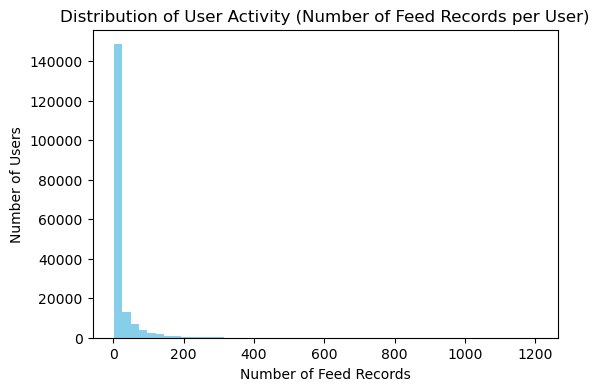

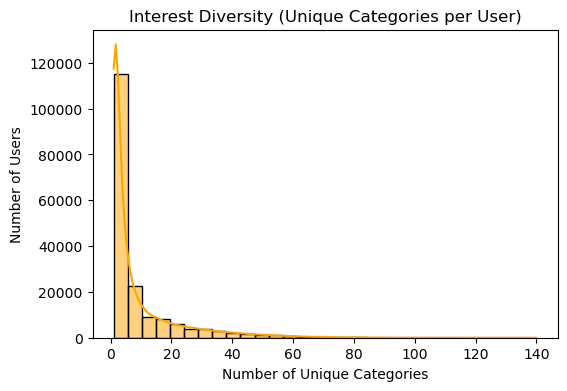

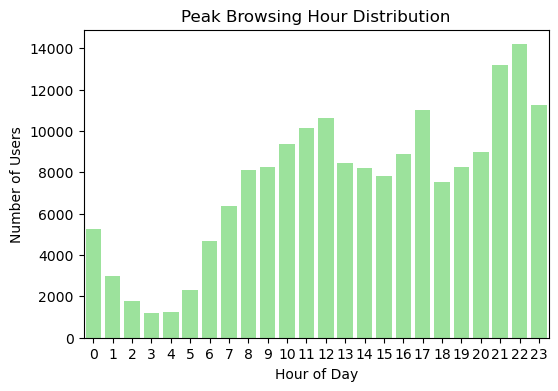

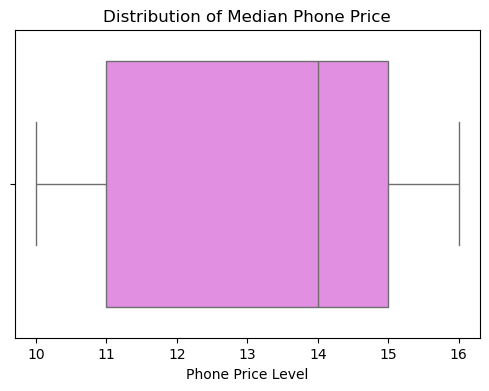

In [19]:
# Step 5 — Light EDA
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
plt.hist(feeds_user_agg_train['f_rows'], bins=50, color='skyblue')
plt.title('Distribution of User Activity (Number of Feed Records per User)')
plt.xlabel('Number of Feed Records')
plt.ylabel('Number of Users')
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(feeds_user_agg_train['f_cat_uniq'], bins=30, color='orange', kde=True)
plt.title('Interest Diversity (Unique Categories per User)')
plt.xlabel('Number of Unique Categories')
plt.ylabel('Number of Users')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='f_peak_hour', data=feeds_user_agg_train, color='lightgreen')
plt.title('Peak Browsing Hour Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Users')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='f_phone_price_median', data=feeds_user_agg_train, color='violet')
plt.title('Distribution of Median Phone Price')
plt.xlabel('Phone Price Level')
plt.show()

## Step 6 — Save Aggregated Datasets

Now that we’ve successfully built user-level behavior summaries,
we’ll save them in Parquet format for efficiency and easy reuse.

These files will later be merged with the ads datasets in Notebook 3.

In [22]:
# Step 6 — Save results for training and test
feeds_user_agg_train.to_parquet('feeds_user_agg_train.parquet', index=False)
feeds_user_agg_test = aggregate_feeds_per_user(feeds_test_clean)
feeds_user_agg_test['f_hour_sin'] = np.sin(2 * np.pi * feeds_user_agg_test['f_avg_hour'] / 24)
feeds_user_agg_test['f_hour_cos'] = np.cos(2 * np.pi * feeds_user_agg_test['f_avg_hour'] / 24)
feeds_user_agg_test.to_parquet('feeds_user_agg_test.parquet', index=False)

print("Saved aggregated datasets:")
print("- feeds_user_agg_train.parquet")
print("- feeds_user_agg_test.parquet")

Aggregating feeds per user...
Aggregation complete! Result shape: (51162, 15)
Saved aggregated datasets:
- feeds_user_agg_train.parquet
- feeds_user_agg_test.parquet
